### 首先运行下基本的命令，检查下Tensorflow环境是否搭建成功

In [1]:
import tensorflow as tf

hello = tf.constant('Hello Tensorflow!')
with tf.Session() as sess:
    print(sess.run(hello))

C:\Users\EWWIQQU\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


b'Hello Tensorflow!'


### 模型选择

- 根据Capstone中给出例子[deep learning models for keras](https://github.com/fchollet/deep-learning-models)看了下其他人是如何使用Keras来预测的
- 选择VGG19,InceptionV3,Xception以及ResNet来根据上方的例子做一个简单的预测,看看什么情况；
- 自定义一个函数根据不同的module name来预测，并输出图片及排名第一的概率；

In [22]:
# Tensorflow搭建成功，再试一下通过VGG19预测一张图片
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.applications import imagenet_utils
from keras.preprocessing import image
import numpy as np
import cv2
import matplotlib.pyplot as plt                        
%matplotlib inline 

def preditcByModuleName(module_name, image_path):
    model = None
    preprocess = imagenet_utils.preprocess_input # default  preprocess
    input_shape = (224, 224) # default shape
    # 根据module name选择构建的模型及input shape和preprocessor
    if(module_name == 'vgg19'):
        model = VGG19(weights='imagenet')
    elif(module_name == 'resnet'):
        model = ResNet50(weights='imagenet')
    elif(module_name == 'xception'):
        model = Xception(weights='imagenet')
        input_shape = (299, 299)
        preprocess = preprocess_input
    elif(module_name == 'inception'):
        model = InceptionV3(weights='imagenet')
        input_shape = (299, 299)
        preprocess = preprocess_input
    else:
        raise ValueError("Module name is not correct!")
    
    # 加载图片并对数据进行预处理    
    img = image.load_img(image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess(x)
    # 预测图片
    preds = model.predict(x)
    P = imagenet_utils.decode_predictions(preds)
    # 合成图片和预测结果并输出
    orig = cv2.imread(image_path)
    (imagenetID, label, prob) = P[0][0]
    cv2.putText(orig, "Label: {}, {:.2f}%".format(label, prob * 100),(10, 30), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
    cv_rgb = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()



===============vgg19==================


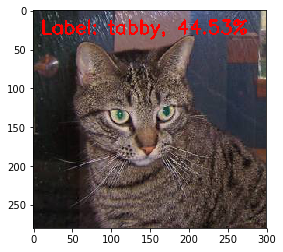

In [23]:
# Test vgg19
img_path = 'data/train/cat/cat.1.jpg'
preditcByModuleName('vgg19', img_path)

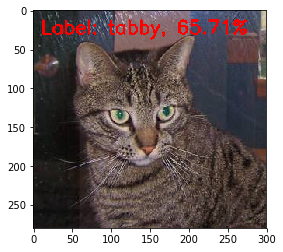

In [24]:
# Test ResNet
preditcByModuleName('resnet', img_path)

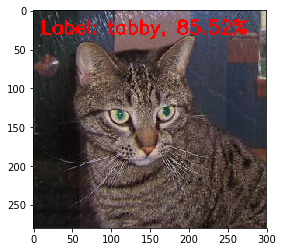

In [25]:
# Test xception
preditcByModuleName('xception', img_path)

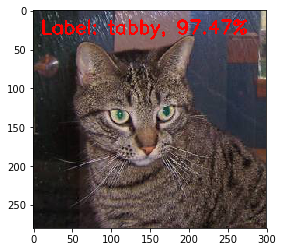

In [26]:
# Test Inception
preditcByModuleName('inception', img_path)